##Importing various packages and data
First we import various packages and our datasets. The datasets has been uploaded to our GitHub-repository, and we use the !wget command to download them.

In [0]:
import pandas as pd
import numpy as np
!pip -q install eli5
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from eli5.lime import TextExplainer
import gensim.downloader as api
import gensim
from gensim.models import Word2Vec, FastText

     |████████████████████████████████| 112kB 2.9MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [0]:
!wget -q https://github.com/JBOzol/m2-group/raw/master/DAX.csv -O DAX.csv
!wget -q https://github.com/JBOzol/m2-group/raw/master/Shanghai.csv -O Shanghai.csv
!wget -q https://github.com/JBOzol/m2-group/raw/master/SP500.csv -O SP500.csv
!wget -q https://github.com/JBOzol/m2-group/raw/master/csv.txt -O csv.txt

Now we can make our dataframes. For now, we make four dataframes: one for each dataset we have fetched.

In [0]:
tweets = pd.read_csv('csv.txt', sep=',')
dax = pd.read_csv('DAX.csv', sep=";")
usa = pd.read_csv('SP500.csv', sep=";")
china = pd.read_csv('Shanghai.csv',sep=";")

We examine the tweets dataframe as it is the most complex.

In [0]:
tweets.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,....He is also my friend! At the same time I a...,10-18-2019 19:34:21,9387,43428,False,1185277957436248065
1,Twitter for iPhone,I want to thank Secretary of Energy Rick Perry...,10-18-2019 19:34:20,11842,56210,False,1185277956551254018
2,Twitter for iPhone,Can you believe I am doing this important work...,10-18-2019 15:51:42,29207,125905,False,1185221926991609862
3,Twitter for iPhone,DEFEAT TERRORISM! https://t.co/8WbnLPgWIK,10-18-2019 15:46:14,16078,61324,False,1185220552254017537
4,Twitter for iPhone,Just spoke to President @RTErdogan of Turkey. ...,10-18-2019 15:42:37,15071,59476,False,1185219641972539392


In [0]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12321 entries, 0 to 12320
Data columns (total 7 columns):
source            12321 non-null object
text              12321 non-null object
created_at        12321 non-null object
retweet_count     12321 non-null int64
favorite_count    12321 non-null int64
is_retweet        12263 non-null object
id_str            12321 non-null int64
dtypes: int64(3), object(4)
memory usage: 673.9+ KB


Now we look into the three indexes.

In [0]:
print(dax.info())
print()
print(usa.info())
print()
print(china.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 4 columns):
Date          768 non-null object
dax_close     768 non-null float64
dax_return    768 non-null float64
dax_op        768 non-null int64
dtypes: float64(2), int64(1), object(1)
memory usage: 24.1+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 4 columns):
Date          767 non-null object
usa_close     767 non-null float64
usa_return    767 non-null float64
usa_op        767 non-null int64
dtypes: float64(2), int64(1), object(1)
memory usage: 24.1+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 4 columns):
Date            736 non-null object
china_close     736 non-null float64
china_return    736 non-null float64
china_op        736 non-null int64
dtypes: float64(2), int64(1), object(1)
memory usage: 23.1+ KB
None


From examining the data, it looks like we need to fix the datetimes so they are similar through-out all four dataframes. We make a while loop to make two new variables: a unix time code variable, and a simple date variable.

We do this for all four dataframes.

In [0]:
import datetime as dt
import time

In [0]:
tweets['timeline'] = pd.to_datetime(tweets['created_at'])
a = 0
b = len(tweets)
c = []
d = []
while a < b :
 c.append(dt.datetime.timestamp(tweets.loc[a].timeline))
 d.append(dt.datetime.date(tweets.loc[a].timeline))
 a += 1
tweets['timeline'] = c
tweets['dato'] = d
tweets.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,timeline,dato
0,Twitter for iPhone,....He is also my friend! At the same time I a...,10-18-2019 19:34:21,9387,43428,False,1185277957436248065,1.571427e+09,2019-10-18
1,Twitter for iPhone,I want to thank Secretary of Energy Rick Perry...,10-18-2019 19:34:20,11842,56210,False,1185277956551254018,1.571427e+09,2019-10-18
2,Twitter for iPhone,Can you believe I am doing this important work...,10-18-2019 15:51:42,29207,125905,False,1185221926991609862,1.571414e+09,2019-10-18
3,Twitter for iPhone,DEFEAT TERRORISM! https://t.co/8WbnLPgWIK,10-18-2019 15:46:14,16078,61324,False,1185220552254017537,1.571414e+09,2019-10-18
4,Twitter for iPhone,Just spoke to President @RTErdogan of Turkey. ...,10-18-2019 15:42:37,15071,59476,False,1185219641972539392,1.571413e+09,2019-10-18


In [0]:
dax['timeline'] = pd.to_datetime(dax['Date'], format='%d-%m-%Y')
a = 0
b = len(dax)
c = []
d = []
while a < b :
 c.append(dt.datetime.timestamp(dax.loc[a].timeline))
 d.append(dt.datetime.date(dax.loc[a].timeline))
 a += 1
dax['timeline'] = c
dax['dato'] = d
dax.head()

,Date,dax_close,dax_return,dax_op,timeline,dato
0,05-10-2016,10585.78027,-0.319580,0,1.475626e+09,2016-10-05
1,06-10-2016,10568.79981,-0.160666,0,1.475712e+09,2016-10-06
2,07-10-2016,10490.86035,-0.742927,0,1.475798e+09,2016-10-07
3,10-10-2016,10624.08008,1.253941,1,1.476058e+09,2016-10-10
4,11-10-2016,10577.16016,-0.443597,0,1.476144e+09,2016-10-11


In [0]:
usa['timeline'] = pd.to_datetime(usa['Date'], format='%d-%m-%Y')
a = 0
b = len(usa)
c = []
d = []
while a < b :
 c.append(dt.datetime.timestamp(usa.loc[a].timeline))
 d.append(dt.datetime.date(usa.loc[a].timeline))
 a += 1
usa['timeline'] = c
usa['dato'] = d
usa.head()

,Date,usa_close,usa_return,usa_op,timeline,dato
0,03-10-2016,2161.199951,-0.327136,0,1.475453e+09,2016-10-03
1,04-10-2016,2150.489990,-0.498024,0,1.475539e+09,2016-10-04
2,05-10-2016,2159.729980,0.427831,1,1.475626e+09,2016-10-05
3,06-10-2016,2160.770020,0.048133,1,1.475712e+09,2016-10-06
4,07-10-2016,2153.739990,-0.326410,0,1.475798e+09,2016-10-07


In [0]:
china['timeline'] = pd.to_datetime(china['Date'], format='%d-%m-%Y')
a = 0
b = len(china)
c = []
d = []
while a < b :
 c.append(dt.datetime.timestamp(china.loc[a].timeline))
 d.append(dt.datetime.date(china.loc[a].timeline))
 a += 1
china['timeline'] = c
china['dato'] = d
china.head()

,Date,china_close,china_return,china_op,timeline,dato
0,11-10-2016,3065.250000,0.558093,1,1.476144e+09,2016-10-11
1,12-10-2016,3058.498047,-0.220760,0,1.476230e+09,2016-10-12
2,13-10-2016,3061.345947,0.093028,1,1.476317e+09,2016-10-13
3,14-10-2016,3063.809082,0.080395,1,1.476403e+09,2016-10-14
4,17-10-2016,3041.166016,-0.744552,0,1.476662e+09,2016-10-17


In [0]:
print(tweets.head())
print('=====================')
print(dax.head())
print('=====================')
print(china.head())
print('=====================')
print(usa.head())

               source  ...        dato
0  Twitter for iPhone  ...  2019-10-18
1  Twitter for iPhone  ...  2019-10-18
2  Twitter for iPhone  ...  2019-10-18
3  Twitter for iPhone  ...  2019-10-18
4  Twitter for iPhone  ...  2019-10-18

[5 rows x 9 columns]
         Date    dax_close  dax_return  dax_op      timeline        dato
0  05-10-2016  10585.78027   -0.319580       0  1.475626e+09  2016-10-05
1  06-10-2016  10568.79981   -0.160666       0  1.475712e+09  2016-10-06
2  07-10-2016  10490.86035   -0.742927       0  1.475798e+09  2016-10-07
3  10-10-2016  10624.08008    1.253941       1  1.476058e+09  2016-10-10
4  11-10-2016  10577.16016   -0.443597       0  1.476144e+09  2016-10-11
         Date  china_close  china_return  china_op      timeline        dato
0  11-10-2016  3065.250000      0.558093         1  1.476144e+09  2016-10-11
1  12-10-2016  3058.498047     -0.220760         0  1.476230e+09  2016-10-12
2  13-10-2016  3061.345947      0.093028         1  1.476317e+09  2016-10-1

Now it looks like we have correctly made the new date variable. We will use this to merge the different dataframes together, so we can look at Donald Trump's tweets on a given day, and compare it to how the markets reacted that day.

To do this, we have to keep in mind, that Trump has multiple tweets on a normal day, and also that the 3 markets have different bank days.

Thus we have to use another loop to merge the dataframes together.

#Exploratory data analysis using visualizations
From the stakeholder report, we formulated a problem:
*How does the markets react to Donald Trumps tweets?*

To answer this we first try to use some exploratory data analysis by visualizing the market changes over time, and compare this to Trump's trade war related tweets.

We define Trump's trade war related tweets by looking at his most used words, where we have created a list of those that are often associated with trade war.


From this list we form a new boolean variable, trade_war, which we will plot together with the stock indexes, hoping to see a correlation between trade war related tweets, and hanges in the stock markets.

In [0]:
b=[]
b.append(min(tweets.dato))
b.append(min(usa.dato))
b.append(min(dax.dato))
b.append(min(china.dato))
c=[]
c.append(max(tweets.dato))
c.append(max(usa.dato))
c.append(max(dax.dato))
c.append(max(china.dato))

df =  pd.DataFrame()
df['earliest'] = b
df['latest'] = c
d = max(df['earliest'])
e = min(df['latest'])
print(d, e)
df.head()

2016-10-11 2019-10-18


,earliest,latest
0,2016-09-30,2019-10-18
1,2016-10-03,2019-10-18
2,2016-10-05,2019-10-18
3,2016-10-11,2019-10-18


In [0]:
df =  pd.DataFrame()
df['datot'] = pd.date_range(start=d, end=e)
df['dato'] = 0
a = len(df)
b = 0
while b < a:
  df.iloc[b,1] = dt.datetime.date(df.iloc[b,0])
  b += 1
df = df.drop('datot', axis=1)
print(len(df))
df.head()

1103


,dato
0,2016-10-11
1,2016-10-12
2,2016-10-13
3,2016-10-14
4,2016-10-15


In [0]:
df1 =  pd.DataFrame()
df2 =  pd.DataFrame()
df3 =  pd.DataFrame()
df4 =  pd.DataFrame()

In [0]:
df1 = tweets[(tweets['dato'] >= d) & (tweets['dato'] <= e)]
df2 = usa[(usa['dato'] >= d) & (usa['dato'] <= e)]
df3 = dax[(dax['dato'] >= d) & (dax['dato'] <= e)]
df4 = china[(china['dato'] >= d) & (china['dato'] <= e)]

In [0]:
df['tweetraw'] = ''
df.head()

,dato,tweetraw
0,2016-10-11,
1,2016-10-12,
2,2016-10-13,
3,2016-10-14,
4,2016-10-15,


In [0]:
count = 0 
stopat = len(df)
liste = []
while count < stopat:
  a = df.loc[count].dato
  b = df1[df1['dato'] == a]
  c = 0
  d = len(b)
  e = ''
  while c < d:
    e += ' ' + b.iloc[c,1]
    c += 1  
  liste.append(e)
  count +=1

In [0]:
df.tweetraw = liste

df = df.merge(df2, left_on='dato', right_on='dato')
df = df.merge(df3, left_on='dato', right_on='dato')
df = df.merge(df4, left_on='dato', right_on='dato')

df.head(15)

,dato,tweetraw,Date_x,usa_close,usa_return,usa_op,timeline_x,Date_y,dax_close,dax_return,dax_op,timeline_y,Date,china_close,china_return,china_op,timeline
0,2016-10-11,Wow @CNN Town Hall questions were given to Cr...,11-10-2016,2136.729980,-1.260334,0,1.476144e+09,11-10-2016,10577.16016,-0.443597,0,1.476144e+09,11-10-2016,3065.250000,0.558093,1,1.476144e+09
1,2016-10-12,I will be in Cincinnati Ohio tomorrow night a...,12-10-2016,2139.179932,0.114528,1,1.476230e+09,12-10-2016,10523.07031,-0.514012,0,1.476230e+09,12-10-2016,3058.498047,-0.220760,0,1.476230e+09
2,2016-10-13,Join me live in Cincinnati Ohio!#TrumpRally #...,13-10-2016,2132.550049,-0.310890,0,1.476317e+09,13-10-2016,10414.07031,-1.046661,0,1.476317e+09,13-10-2016,3061.345947,0.093028,1,1.476317e+09
3,2016-10-14,Make sure you're registered to vote! Let's #M...,14-10-2016,2132.979980,0.020156,1,1.476403e+09,14-10-2016,10580.37988,1.571868,1,1.476403e+09,14-10-2016,3063.809082,0.080395,1,1.476403e+09
4,2016-10-17,Get rich quick! Crooked Hillary Clinton's pay...,17-10-2016,2126.500000,-0.304725,0,1.476662e+09,17-10-2016,10503.57031,-0.731271,0,1.476662e+09,17-10-2016,3041.166016,-0.744552,0,1.476662e+09
5,2016-10-18,'Trump rally disrupter was once on Clinton's ...,18-10-2016,2139.600098,0.612269,1,1.476749e+09,18-10-2016,10631.54981,1.203771,1,1.476749e+09,18-10-2016,3083.875000,1.384913,1,1.476749e+09
6,2016-10-19,UNBELIEVABLE!Clinton campaign contractor caug...,19-10-2016,2144.290039,0.218718,1,1.476835e+09,19-10-2016,10645.67969,0.132729,1,1.476835e+09,19-10-2016,3084.718994,0.027360,1,1.476835e+09
7,2016-10-20,Hillary &amp; Obama's Broken Promises. #Repea...,20-10-2016,2141.340088,-0.137762,0,1.476922e+09,20-10-2016,10701.38965,0.520586,1,1.476922e+09,20-10-2016,3084.458008,-0.008461,0,1.476922e+09
8,2016-10-21,#CrookedHillary sending U.S. intelligence inf...,21-10-2016,2141.159912,-0.008415,0,1.477008e+09,21-10-2016,10710.73047,0.087210,1,1.477008e+09,21-10-2016,3090.940918,0.209739,1,1.477008e+09
9,2016-10-24,Peter Navarro: 'Trump the Bull vs. Clinton th...,24-10-2016,2151.330078,0.472739,1,1.477267e+09,24-10-2016,10761.16992,0.468717,1,1.477267e+09,24-10-2016,3128.247070,1.192558,1,1.477267e+09


In [0]:
df["trade_war"] = df["tweetraw"].str.contains("tarif|china|eu|union|steel|trade|trading|import|export|money|unemploy|commerce|mercant|deal|business|barter|merch|arbitrage|advantage|stock|brexit", na=False)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 703 entries, 0 to 702
Data columns (total 18 columns):
dato            703 non-null object
tweetraw        703 non-null object
Date_x          703 non-null object
usa_close       703 non-null float64
usa_return      703 non-null float64
usa_op          703 non-null int64
timeline_x      703 non-null float64
Date_y          703 non-null object
dax_close       703 non-null float64
dax_return      703 non-null float64
dax_op          703 non-null int64
timeline_y      703 non-null float64
Date            703 non-null object
china_close     703 non-null float64
china_return    703 non-null float64
china_op        703 non-null int64
timeline        703 non-null float64
trade_war       703 non-null bool
dtypes: bool(1), float64(9), int64(3), object(5)
memory usage: 99.5+ KB


In [0]:
df['trade_war'].value_counts()

True     363
False    340
Name: trade_war, dtype: int64

In [0]:
new_tweets = df.drop(['Date_x','timeline_x','Date_y','timeline_y','Date','timeline'], axis=1)

In [0]:
new_tweets.to_csv('new_merge.csv')

In [0]:
new_tweets.dropna(axis='columns')
new_tweets2 = new_tweets[new_tweets['trade_war']==True]

In [0]:
new_tweets2.head()

,dato,tweetraw,usa_close,usa_return,usa_op,dax_close,dax_return,dax_op,china_close,china_return,china_op,trade_war
7,2016-10-20,Hillary &amp; Obama's Broken Promises. #Repea...,2141.340088,-0.137762,0,10701.38965,0.520586,1,3084.458008,-0.008461,0,True
15,2016-11-01,RT @DanScavino: Join @realDonaldTrump LIVE in...,2111.719971,-0.683326,0,10526.16016,-1.319091,0,3122.436035,0.702788,1,True
21,2016-11-09,Such a beautiful and important evening! The f...,2163.260010,1.095566,1,10646.00977,1.537566,1,3128.370117,-0.623897,0,True
23,2016-11-11,Today we express our deepest gratitude to all...,2164.449951,-0.139991,0,10667.95020,0.354614,1,3196.043945,0.774769,1,True
30,2016-11-22,I am seriously considering Dr. Ben Carson as ...,2202.939941,0.216075,1,10713.84961,0.268062,1,3248.352051,0.929828,1,True


In [0]:
new_tweets2['trade_war'].value_counts()

True    363
Name: trade_war, dtype: int64

Now that we have generated our new variable, it seems like we have a total of 1074 tweets, that are trade war related.

We can now begin to visualize the indexes and compare them to Trump's tweets.

We first look at DAX:

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


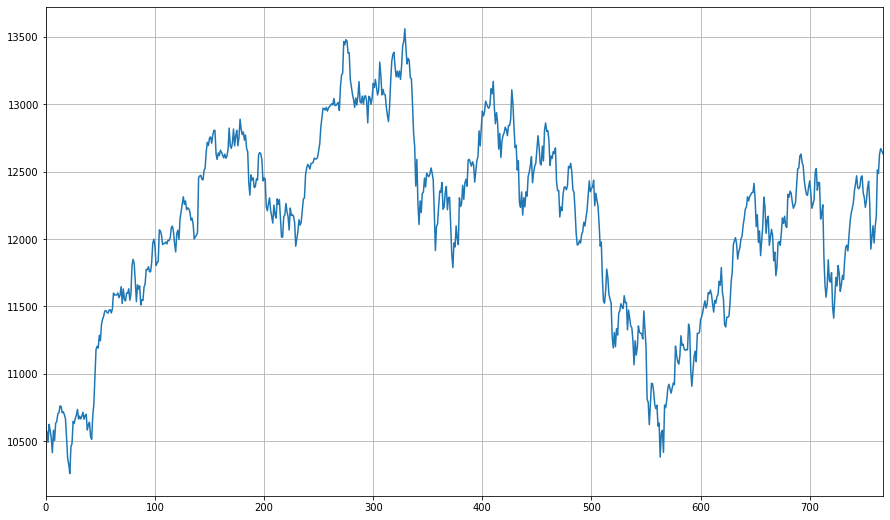

In [0]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
dax["dax_close"].plot(grid = True) # Plot the adjusted closing price of index

For a more indepth plot, we kindly refer you to take a look on our GitHub page, where we have made those plots in R. They are accesible via 

We now look at the Chinese stock market, Shanghai Stock Exchange.

Populating the interactive namespace from numpy and matplotlib


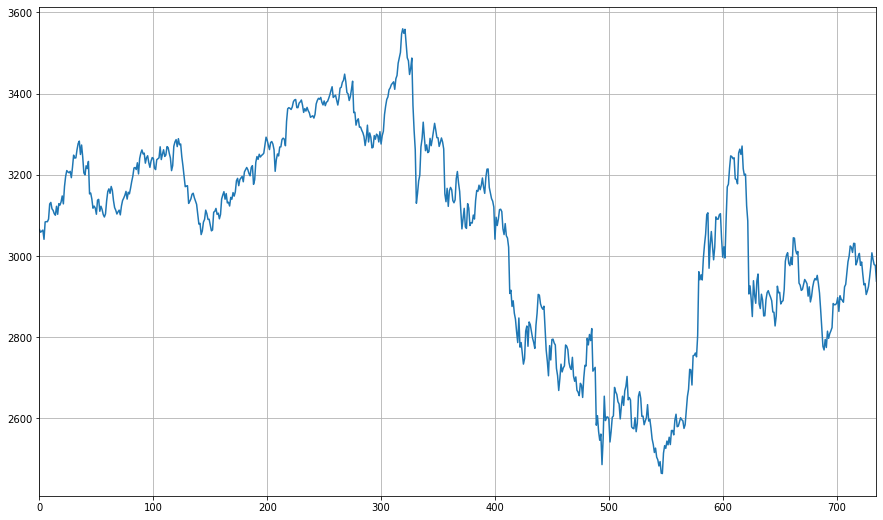

In [0]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
china["china_close"].plot(grid = True) # Plot the adjusted closing price of index

From above it looks like the Chinese stock market reacts [this other way] to Trump's tweets.

Finally we look at the American S&P 500 stock index.

Populating the interactive namespace from numpy and matplotlib


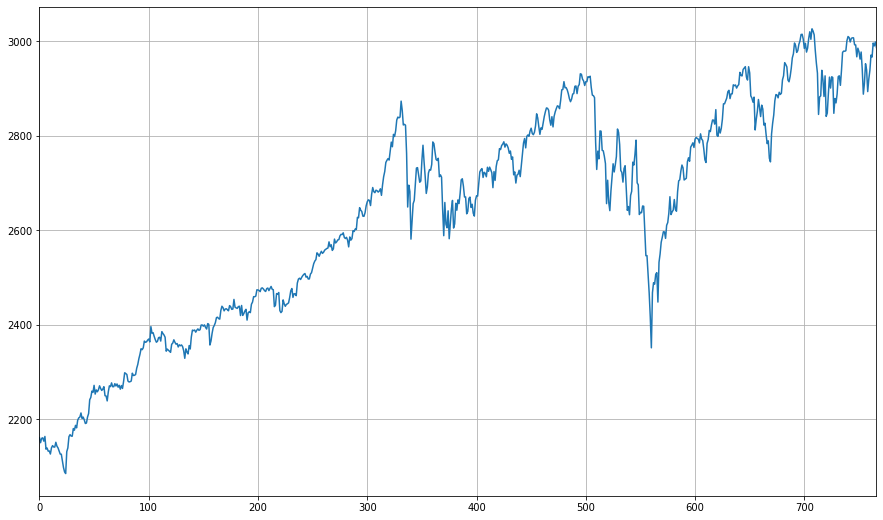

In [0]:
import matplotlib.pyplot as plt   # Import matplotlib
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
 
usa["usa_close"].plot(grid = True) # Plot the adjusted closing price of index

From this, it looks like the market reacts this way to his tweets.

Now that we have established, that it looks like the markets reacts to Trump's tweets, we can also try to use some natural language processing in combination with machine learning techniques to further investigate those reactions.

#Tokenizing and vectorizing the tweets
We first tokenize and vectorize Trump's tweets. We also split our data into a train and test set.

We make a pipeline where we first use TfidfVectorizer, followed by the TruncatedSVD function.

After this we make a list of all the tweets, followed by splitting the tweets into sentences.

In [0]:
train_df = new_tweets2.iloc[:182]
test_df = new_tweets2.iloc[182:]

In [0]:
#Defining a pipeline
vec = TfidfVectorizer()
svd = TruncatedSVD(n_components=200, n_iter=7, random_state=42)

lsa = make_pipeline(vec, svd)

In [0]:
#Creating list of tweets
texts = list(train_df.tweetraw)

texts.extend(test_df.tweetraw) 

In [0]:
test_df.head()

,dato,tweetraw,usa_close,usa_return,usa_op,dax_close,dax_return,dax_op,china_close,china_return,china_op,trade_war
429,2018-08-07,Today on the 236th anniversary of the Purple ...,2858.449951,0.281623,1,12648.19043,0.395159,1,2779.374023,2.670279,1,True
430,2018-08-08,RED WAVE! Congratulations to @LenaEpstein of ...,2857.699951,-0.026245,0,12633.54004,-0.115964,0,2744.070068,-1.286554,0,True
432,2018-08-10,Deal with Mexico is coming along nicely. Auto...,2833.280029,-0.716486,0,12424.34961,-2.026349,0,2795.310059,0.033198,1,True
433,2018-08-13,It was my great honor to sign our new Defense...,2821.929932,-0.402210,0,12358.74023,-0.530874,0,2785.872070,-0.338780,0,True
434,2018-08-14,“Hope and Change in an Alabama Coal Mine” htt...,2839.959961,0.634869,1,12358.87012,0.001051,1,2780.965088,-0.176449,0,True


In [0]:
#Splitting sentences
sents = []
for text in texts:
  sents.extend(sent_tokenize(text))

Now that we have split the tweets into sentences, we tokenize the texts, where we also make everything lower-case.

We also define some stop-words, so we can filter those out.

In [0]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

In [0]:
[word.lower() for word in word_tokenize(text) if word not in stop_words and word.isalnum()]

['also',
 'friend',
 'at',
 'time',
 'i',
 'pleased',
 'nominate',
 'deputy',
 'secretary',
 'dan',
 'brouillette',
 'new',
 'secretary',
 'energy',
 'dan',
 'experience',
 'sector',
 'unparalleled',
 'a',
 'total',
 'professional',
 'i',
 'doubt',
 'dan',
 'great',
 'job',
 'i',
 'want',
 'thank',
 'secretary',
 'energy',
 'rick',
 'perry',
 'outstanding',
 'job',
 'done',
 'he',
 'leaving',
 'end',
 'year',
 'pursue',
 'interests',
 'rick',
 'great',
 'governor',
 'texas',
 'great',
 'secretary',
 'energy',
 'can',
 'believe',
 'i',
 'important',
 'work',
 'country',
 'deal',
 'corrupt',
 'adam',
 'schiff',
 'do',
 'nothing',
 'democrats',
 'time',
 'it',
 'intended',
 'way',
 'president',
 'defeat',
 'terrorism',
 'https',
 'just',
 'spoke',
 'president',
 'rterdogan',
 'turkey',
 'he',
 'told',
 'minor',
 'sniper',
 'mortar',
 'fire',
 'quickly',
 'eliminated',
 'he',
 'much',
 'wants',
 'ceasefire',
 'pause',
 'work',
 'likewise',
 'kurds',
 'want',
 'ultimate',
 'solution',
 'hap

In [0]:
#Tokenized sentences/texts
tokenized_texts = [word_tokenize(text) for text in sents]
tokenized_texts = list(map(lambda x: [y.lower() for y in x], tokenized_texts))

Now that our tweets are tokenized, we can begin building our model.

In [0]:
#Defining my model
model = Word2Vec(tokenized_texts, 
                 size=300,      
                 min_count=10,  
                 window=8,
                 max_final_vocab = 3000).wv  

In [0]:
words = sorted(model.vocab.keys(), 
               key=lambda word: model.vocab[word].count,
               reverse=True)[:1000]

In [0]:
#Returning word vectors
word_vectors = model.vectors[[model.vocab[word].index for word in words]]

We can now make some plotting of the vectorized words. We use the bokeh modules to make som neat interactive plots.

In [0]:
#Making a bokeh plot for some neat interactive plots
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig

In [0]:
#Word vectors to 2 dimensions for bokeh plot
import umap

def get_umap_projection(word_vectors):
    vecs = umap.UMAP(n_neighbors=15, metric='cosine').fit_transform(word_vectors)
    return vecs

In [0]:
word_umap = get_umap_projection(word_vectors[:1000])
draw_vectors(word_umap[:, 0], word_umap[:, 1], color='blue', token=words)

Figure(id='1002', ...)

From the plots we can see that we have in fact managed to vectorize the words.

Next step will be to determine a new model using the wiki gigaword 300 preloaded model.

In [0]:
#Assigning preloaded model
model = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


We use Roman's helper function to help vectorize.

In [0]:
#Romans helper function to vectorize
def get_phrase_embedding(model, phrase):    
    vector = np.zeros([model.vector_size], dtype='float32')
    if type(phrase) == str:
      phrase = list(map(lambda x: x.lower(), word_tokenize(phrase)))
    vecs = [model.get_vector(tok) for tok in phrase if tok in model.wv.vocab]
    if len(vecs) == 0:
      return vector
    else:
      vector = sum(vecs)/len(vecs)
      return vector

In [0]:
#Importing multiprocessing tool to map the tweets faster
import multiprocessing
p = multiprocessing.Pool()

train_df_tweet_tok = p.map(word_tokenize, train_df.tweetraw)
test_df_tweet_tok = p.map(word_tokenize, test_df.tweetraw)

In [0]:
#Vectorizing train and test set
text_vectors_train = np.array([get_phrase_embedding(model, phrase) for phrase in train_df_tweet_tok])
text_vectors_test = np.array([get_phrase_embedding(model, phrase) for phrase in test_df_tweet_tok])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


Now that we have everything vectorized it's a simple matter of using a classifier, e.g. LogisticRegression and fit our text_vectors_train to our market reactions.

In [0]:
text_vectors_train = np.reshape(text_vectors_train,(-1,1))
text_vectors_test = np.reshape(text_vectors_test,(-1,1))

In [0]:
#Training model
clf1 = LogisticRegression()
clf2 = XGBClassifier()
pred1 = clf1.fit(text_vectors_train,train_df['usa_op'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
pred2 = clf1.fit(text_vectors_train,train_df['dax_op'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
pred3 = clf1.fit(text_vectors_train,train_df['china_op'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
print('US precision:')
print(pred1.score(text_vectors_test,test_df['usa_op']))
print()
print('DAX precision')
print(pred2.score(text_vectors_test,test_df['dax_op']))
print()
print('China precision')
print(pred3.score(text_vectors_test,test_df['china_op']))

US precision:
0.5303867403314917

DAX precision
0.5248618784530387

China precision
0.48066298342541436


Looking at above, it seems like the model using Trump tweets has a precision of 0.53 when trying to predict movements in the US market, 0.52 when predicting the European market, and 0,48 when predicting the Chinese market.

Those precisions are overall very low, thus it doesn't seem like those tweets alone are causing volatility in the stock markets.

Trying with another classifier, XGBoost, gives similar results.

In [0]:
pred4 = clf2.fit(text_vectors_train,train_df['usa_op'])
print(pred4.score(text_vectors_test,test_df['usa_op']))
pred5 = clf2.fit(text_vectors_train,train_df['dax_op'])
print(pred5.score(text_vectors_test,test_df['dax_op']))
pred6 = clf2.fit(text_vectors_train,train_df['china_op'])
print(pred6.score(text_vectors_test,test_df['china_op']))

0.5248618784530387
0.5414364640883977
0.574585635359116


Using XGBoost gives slightly lower precision for the US market, but slightly better for the European and Chinese markets.

With those results in mind, our final conclusion is, that we cannot reliably predict the market movements using Trump's trade war related tweets.